**Document Embeddings**

In [1]:
###
# Setup
###
import numpy as np
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')

# word2vec requires sentences as input
from txt_utils import get_sentences
sentences = []
for doc in df1['snippet']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

**Average word2vec Embeddings**

In [2]:
###
# Make document vectors by averaging word embeddings in a document
##

# Continuous bag-of-words representation
from gensim.models import Word2Vec
w2v = Word2Vec.load('w2v-vectors.pkl')

sentvecs = []
for sentence in sentences:
    vecs = [w2v.wv[w] for w in sentence if w in w2v.wv]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
sentvecs[0][0][:30]

array([-0.01565365,  0.03890735,  0.04957038,  0.02919591,  0.02055856,
        0.04036769,  0.03311942,  0.02373208,  0.03268646,  0.02614455,
        0.03679549,  0.00379873, -0.06405071,  0.04071577,  0.02150792,
       -0.00386672, -0.03841546,  0.05122682,  0.02182901, -0.01132445,
       -0.02120029,  0.01947568, -0.0161361 , -0.01752919, -0.01343895,
        0.01516963,  0.00354652,  0.01580906,  0.00158723, -0.01405498],
      dtype=float32)

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sentvecs[0],
                  sentvecs[1])[0][0]

0.7454929

**Doc2Vec**

In [4]:
###
# Doc2Vec
###

from nltk import word_tokenize
docs = []

for i, row in df1.iterrows():
    docs += [word_tokenize(row['snippet'])]
shuffle(docs)

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
doc_iterator = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
d2v = Doc2Vec(doc_iterator,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size

In [6]:
d2v.save('d2v-vectors.pkl')

In [7]:
# matrix of all document vectors:
D = d2v.docvecs.vectors_docs
D.shape

(32567, 100)

In [8]:
D

array([[ 0.01007203, -0.01151024, -0.00695012, ..., -0.02537265,
        -0.00462733, -0.01064147],
       [ 0.00509031, -0.00198077,  0.00088507, ..., -0.01894499,
         0.00394   , -0.01748081],
       [-0.0034143 , -0.01275815,  0.01953427, ..., -0.0873723 ,
        -0.00251018, -0.02113085],
       ...,
       [-0.0022999 , -0.01810182, -0.00512756, ..., -0.02926789,
        -0.00121112,  0.00011984],
       [ 0.0062967 , -0.00489218,  0.00093279, ..., -0.010656  ,
         0.00338361, -0.00755452],
       [-0.01195034,  0.00855388,  0.0177092 , ..., -0.02047521,
         0.00307176, -0.00900842]], dtype=float32)

In [9]:
# infer vectors for new documents
a = d2v.infer_vector(['the judge on the court'])

b = d2v.infer_vector(['the jury and the judge'])

c = d2v.infer_vector(['cats hunt mice'])

In [10]:
a.shape, b.shape
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(b, axis=0)))
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(c, axis=0)))


[[0.18632594]]
[[0.14812855]]


In [11]:
# get all pair-wise document similarities
pairwise_sims = cosine_similarity(D)
pairwise_sims.shape

(32567, 32567)

In [12]:
pairwise_sims[:3,:3]

array([[1.0000001, 0.901857 , 0.9176217],
       [0.901857 , 0.9999999, 0.9137324],
       [0.9176217, 0.9137324, 1.0000002]], dtype=float32)

In [13]:
# Document clusters
from sklearn.cluster import KMeans

# create 50 clusters of similar documents
num_clusters = 50
kmw = KMeans(n_clusters=num_clusters)
kmw.fit(D)

KMeans(n_clusters=50)

In [14]:
# Documents from an example cluster
for i, doc in enumerate(docs):
    if kmw.labels_[i] == 25:
        print(' '.join(doc[:9]))
    if i == 1000:
        break

committed to imposing the death penalty . She stated
( g ) Propriety of the Death Penalty Defendant
option of giving the death penalty ? A .
for cause jurors who are unable to impose the
have any moral or religious objections to the death
jurors indicated that she had qualms about the death
participating . O P I N I O N
unconstitutionality of the death penalty in Missouri . First
complains that a portion of the Witherspoon , or


In [15]:
# t-SNE for visualization
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
# d2v_tsne = tsne.fit_transform(D)

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(D)
pca.explained_variance_ratio_

array([0.7556026 , 0.06575315, 0.03936772], dtype=float32)

In [17]:
#vdf = pd.DataFrame(Xpca,
#                  columns=['x-tsne', 'y-tsne'])
#vdf['cluster'] = kmw.labels_

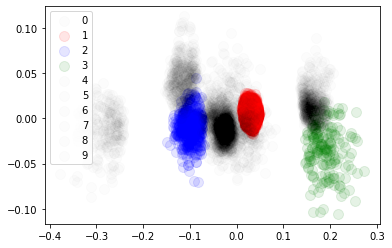

In [19]:
#%% PCA Viz
import matplotlib.pyplot as plt

#plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)

cdict = {1: 'red', 2: 'blue', 3: 'green'}
fig, ax = plt.subplots()
#for g, label in cdict.items():
for g in np.unique(kmw.labels_):
    ix = np.where(kmw.labels_ == g)
    #ix = np.where(kmw == g)
    #    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
    if g in cdict:
        # use color from cdict
        color = cdict[g]
        ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.1)
    else:
        if g < 10:
            color = "black"
            ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.01)
    

        
ax.legend()
plt.show()

In [20]:
# sample 100 texts to show different document embeddings techniques

texts = df1["snippet"][:100]
text = texts[0]
text, texts

('N.J.   ( )\n  A. d  \nIN RE WAIVER OF DEATH PENALTY.\nThe Supreme Court of New Jersey.\nSeptember & ; and County Court Judges\n\nRe: Waiver of the Death Penalty\n*  The Supreme Court is concerned by the excessive& ;cases where the prosecutor is not seeking the death penalty. It is cognizant of the fact that this situation& ;Although the prosecutor had a right to waive the death penalty and so inform the jury, the jury nevertheless& ;would assume, as did the prosecutor, that the death penalty would not be returned as it was not asked for',
 0     N.J.   ( )\n  A. d  \nIN RE WAIVER OF DEATH PE...
 1     whether the death penalty is, per se, unconsti...
 2     # ;s contention that the assessment of the dea...
 3     . d   ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...
 4     assume the district attorney orally waived the...
                             ...                        
 95    guilty as to all defendants and imposing the d...
 96     present death penalty statutes, juries could .

**Other types of Document Embeddings**

In [21]:
# spacy embeddings (= averaged gloVe embeddings)

import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp(text)
doc.vector

array([ 0.20430338, -0.2567533 , -0.02306902, -0.8766618 ,  0.95168144,
       -0.02246722,  0.66894627,  0.4406781 , -0.6752475 ,  0.9030032 ,
        0.58323574, -0.42557463,  0.3588796 ,  0.7357971 , -0.6806984 ,
        0.35501376, -0.04721715,  0.20714815, -0.4822883 ,  0.32712767,
       -0.2222287 ,  0.42462564,  1.0001506 , -1.0555578 ,  0.24779357,
        0.89857805, -1.7120546 , -1.3771088 , -0.4918279 , -0.70307416,
       -0.02710542, -0.78331864,  0.19273752, -0.55076206, -0.5462378 ,
        0.20845698,  0.12983356, -0.28522107, -0.26439404, -0.32552677,
        1.266796  ,  0.3650614 ,  0.5329269 , -0.45635462,  0.8055457 ,
       -0.86057615,  0.07101551,  0.9271979 ,  0.07538687,  0.5181876 ,
       -0.86646116, -0.8433204 , -0.6902801 , -0.7334907 ,  0.06175952,
        1.0599734 ,  0.36529124,  0.9412022 , -0.46317074,  0.21488601,
       -0.06826341, -0.24556416,  0.9832385 , -0.9066351 , -0.5355074 ,
        1.384116  ,  0.78551155, -0.21280114,  0.50987977,  0.09

**Uinversal Sentence Encoder**

In [22]:
# universal sentence encoder
!pip install --upgrade tensorflow-hub

In [23]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

embeddings = embed([text])

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    text_encoded = session.run(embeddings)



module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [24]:
text_encoded

array([[-5.75881824e-02, -4.48679030e-02, -5.97576126e-02,
        -9.60363168e-03,  4.87335995e-02, -7.14329928e-02,
         5.63881639e-03, -4.17736433e-02,  6.94411248e-02,
        -7.18879625e-02,  4.38294820e-02,  4.96255234e-02,
         2.92646587e-02,  5.06393984e-02,  5.02831228e-02,
        -5.43750636e-02,  1.20794239e-05,  3.34073193e-02,
        -2.29960158e-02,  5.17977662e-02,  1.33965146e-02,
         2.34781913e-02,  6.57833815e-02, -2.41349339e-02,
        -5.89741208e-02,  4.48849648e-02,  8.91342852e-03,
        -1.31372968e-02, -5.10081872e-02,  8.32203683e-03,
         3.43775153e-02, -6.50016218e-02,  3.18928063e-02,
        -5.33328876e-02, -6.16215728e-02, -6.11270331e-02,
        -4.20963168e-02,  1.39375571e-02,  6.44128211e-03,
         6.65995404e-02, -3.60511839e-02, -1.41065717e-02,
        -7.03568989e-03, -4.17812057e-02, -4.14931811e-02,
         5.47352843e-02,  2.42106542e-02, -6.66408762e-02,
        -3.75430100e-02, -5.52068017e-02, -5.62858582e-0

**SBERT**

In [25]:
!pip install sentence-transformers

In [26]:
from sentence_transformers import SentenceTransformer
model = "bert-base-nli-mean-tokens"
embedder = SentenceTransformer(model)
text_encoded = embedder.encode([text])

/home/dominsta/anaconda3/envs/legal_dna/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [27]:
text_encoded

array([[-4.94830966e-01, -3.07748556e-01,  2.38643914e-01,
        -1.12242237e-01,  3.68262798e-01, -2.13435546e-01,
         8.10864329e-01, -2.53932685e-01,  8.49518925e-02,
         4.34111170e-02, -5.32024261e-03,  4.72682863e-01,
         9.99894589e-02,  4.15400177e-01, -1.31251180e+00,
         4.92496759e-01,  1.40618742e-01, -3.23016375e-01,
         1.41712904e-01, -3.53501439e-01,  4.34756912e-02,
        -7.69812390e-02,  2.29930565e-01,  5.27145088e-01,
         9.18621957e-01,  6.17869616e-01, -5.80663562e-01,
         2.21835509e-01, -7.82554150e-01,  5.84526479e-01,
        -1.58552855e-01,  2.56740063e-01, -1.15312088e+00,
         5.24759712e-03,  6.55009449e-02,  5.42442739e-01,
         1.94233000e-01, -1.94006115e-01,  2.46753126e-01,
         1.75806195e-01, -6.84099078e-01,  1.05391599e-01,
        -3.26745361e-01, -2.70014197e-01, -1.21031448e-01,
        -4.18343723e-01,  1.40245199e+00,  4.35339093e-01,
         9.15403306e-01, -1.82648867e-01,  3.20812911e-0